In [0]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print 'yo'
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()
    
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def load_data(filename, seq_len, normalise_window):
    
    df = pd.read_csv(filename)
    df = df["Close"]
    df = df.iloc[1:]
    data = np.array(df)
    
    close_ = []    
    sequence_length = seq_len 
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
        close_.append(data[index+sequence_length])
        
        
    
    y_values = [row[0] for row in result]
    y_values = np.array(y_values)
    print(y_values)

    
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)
    
    #result = np.array(df)
    print(result.shape)
    
    row = round(0.9 * len(result))
    #train = result[:int(row)]
    
    
    train = result[:int(row), :]
    #np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    #y_train = np.roll(y_train, shift=-10)
    x_test = result[int(row):, :-1]
    close_ = close_[int(row):]
    close_ = np.array(close_)

    y_test = result[int(row):, -1]
    #y_test = np.roll(y_test, shift=-10)
    
    print("Train Shape" ,train.shape)
    
    #print(train)
    #print(row)
    #np.random.shuffle(train)
    
    
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    #print((x_train))
    #print((y_train))
    #print(x_test)
    #print(y_test)

    return [x_train, y_train, x_test, y_test, y_values, close_]

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print "Compilation Time : ", time.time() - start
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        print("Curr_frame",curr_frame.shape)
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            print("Predicted ",predicted[0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=1)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [0]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import pandas as pd
import matplotlib.pyplot as plt
from numpy import newaxis
plt.style.use('ggplot')

In [159]:
import numpy as np
#Step 1 Load Data
x_train, y_train, x_test, y_test, y_values, close_ = load_data('Nifty_Techathlon_converted_prks.csv', 10, True)

[ 8523.05  8530.25  8526.55 ... 10137.35 10135.35 10115.  ]
(55789, 10)
('Train Shape', (50210, 10))


In [39]:
print(x_train[:3])

[[[8523.05]
  [8530.25]
  [8526.55]
  [8527.  ]
  [8519.9 ]
  [8523.55]
  [8528.3 ]
  [8526.  ]
  [8528.8 ]]

 [[8530.25]
  [8526.55]
  [8527.  ]
  [8519.9 ]
  [8523.55]
  [8528.3 ]
  [8526.  ]
  [8528.8 ]
  [8529.85]]

 [[8526.55]
  [8527.  ]
  [8519.9 ]
  [8523.55]
  [8528.3 ]
  [8526.  ]
  [8528.8 ]
  [8529.85]
  [8527.55]]]


In [40]:
print(y_train[:2])

[8529.85 8527.55]


In [41]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

IndexError: ignored

In [128]:
#Initialize model 
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(output_dim=1))

model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print 'compilation time : ', time.time() - start

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=50, return_sequences=True, input_shape=(None, 1))`
  


compilation time :  0.0237050056458


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  


In [130]:
#Atleast 10 epochs
model.fit(x_train,y_train,epochs=15)

Epoch 1/20
50210/50210 [==============================] - 75s 1ms/step - loss: 8.4098e-06
Epoch 2/20
50210/50210 [==============================] - 75s 1ms/step - loss: 2.7561e-06
Epoch 3/20
50210/50210 [==============================] - 75s 1ms/step - loss: 2.3298e-06
Epoch 4/20
50210/50210 [==============================] - 74s 1ms/step - loss: 2.1142e-06
Epoch 5/20
50210/50210 [==============================] - 74s 1ms/step - loss: 1.9934e-06
Epoch 6/20
50210/50210 [==============================] - 75s 1ms/step - loss: 1.9003e-06
Epoch 7/20
50210/50210 [==============================] - 74s 1ms/step - loss: 1.8081e-06
Epoch 8/20
50210/50210 [==============================] - 75s 1ms/step - loss: 1.7500e-06
Epoch 9/20
50210/50210 [==============================] - 75s 1ms/step - loss: 1.7243e-06
Epoch 10/20
50210/50210 [==============================] - 75s 1ms/step - loss: 1.6889e-06
Epoch 11/20
50210/50210 [==============================] - 75s 1ms/step - loss: 1.6379e-06
Epoch 12

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, None, 50)          10400     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [0]:
predictions = predict_point_by_point(model, x_test)

In [0]:
#Get predictions for normalised test data
predictions = model.predict(x_test)

In [0]:
#Define a cost function for our predictiona
def cost(y, h):
  c = 0
  for i in range(len(y)):
    c += (h[i] - y[i])**2
  c = c / len(y)
  return c

In [82]:
#Variance for our model
cost(predictions, y_test)

array([1.2579177e-06], dtype=float32)

(-0.005, 0.005)

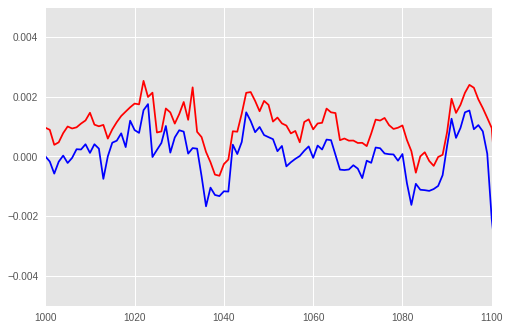

In [138]:
#Plot and visualize the predicted Value
plt.plot(predictions,'r')
plt.plot(y_test,'b')
plt.xlim([1000,1100])
plt.ylim([-0.005,0.005])

In [135]:
#Variance for our model
cost(predictions, y_test)

1.8819639984781836e-06

In [109]:
#Standard Deviation for our model
cost(actual_predicted, actual_true)**2

array([7840.064], dtype=float32)

In [0]:
#To get predictions in multiple steps.
predictions = predict_sequences_multiple(model, x_test, 50, 50)

In [0]:
#The available action space
actions = ['Buy', 'Sell', 'Sit']
action_nums = [-1, 1, 0]

predicted_array = np.array(predictions)

def sharpe(close,action):
    returns = np.ones(len(close)-1)
    for i in range(len(close)-1):
        returns[i] = (close[i+1]-close[i])*action[i]/close[i]
    return returns.mean()/returns.std()



def get_sharpe(threshold):

    actions_ = []
    for i in range(len(predicted_array)-1):
        if((predicted_array[i+1]-predicted_array[i]) > threshold):
            actions_.append(1)
        elif(predicted_array[i+1]-predicted_array[i] < threshold):
            actions_.append(-1)
        else:
            actions_.append(0)
    actions_.append(0)        
    actions_ = np.array(actions_)
    return (sharpe(close_,actions_),actions_)
    
    


In [179]:
max_sharpe = 0
#Method to get optimum threshold value
for i in range(1,1000000):
  
  now_sharpe =get_sharpe(i*0.0000001)
  
  if(now_sharpe > max_sharpe):
    max_sharpe = now_sharpe
    threshold = i
    print(threshold)

1
35
37
38
171
173
241
253
254
256
257
261
264
267
270
295
296
297
322
327
328
343
349
352
356
2293
2512
2514
2536
2540
2631
2636
2637
2880
2881
2884
2885
2887
2916
2922
2925
4470
4475
4491
4492
4496
4504
4512
4513
4518
4554
4562
4571
4574
4576
4625
4666
4671
4684
4710
4719
4725
4730
4735


KeyboardInterrupt: ignored

In [181]:
get_sharpe(0.00047349999999999996)

0.032039987513680285

In [182]:
def trades_(actions):
  trades = 0
  past_action = actions[0]
  for action in actions:
    
    if action != past_action:
      trades += 1
  return trades

trades_(actions_)

594

In [0]:
#Let's Say you require only fixed number of trades
#this function can be used.
def fixed_number_of_trades(trades):
  threshold = 0.0001
  decay = 1e-4
  
  sharpe_,  actions = get_sharpe(threshold)
  no_trades = trades_(actions)
  
  while( no_trades > trades*(1.1) or no_trades < trades*(-1.1)):
        threshold = threshold+decay
        sharpe_, actions = get_sharpe(threshold)
        no_trades = trades_(actions)
        print("Number of trades : ",no_trades)
        print("Threshold ",threshold)
  

In [199]:
fixed_number_of_trades(300)

('Number of trades : ', 2069)
('Threshold ', 0.0002)
('Number of trades : ', 1764)
('Threshold ', 0.00030000000000000003)
('Number of trades : ', 1533)
('Threshold ', 0.0004)
('Number of trades : ', 1298)
('Threshold ', 0.0005)
('Number of trades : ', 1111)
('Threshold ', 0.0006000000000000001)
('Number of trades : ', 933)
('Threshold ', 0.0007000000000000001)
('Number of trades : ', 790)
('Threshold ', 0.0008000000000000001)
('Number of trades : ', 675)
('Threshold ', 0.0009000000000000002)
('Number of trades : ', 594)
('Threshold ', 0.0010000000000000002)
('Number of trades : ', 513)
('Threshold ', 0.0011000000000000003)
('Number of trades : ', 439)
('Threshold ', 0.0012000000000000003)
('Number of trades : ', 386)
('Threshold ', 0.0013000000000000004)
('Number of trades : ', 337)
('Threshold ', 0.0014000000000000004)
('Number of trades : ', 287)
('Threshold ', 0.0015000000000000005)
